# Trabalho de Banco de Dados



### O dataset escolhido mostra os focos de queimadas e incêndios florestais que aconteceram no Brasil durante os dias 15/11/2021 e 16/11/2021. Escolhemos apenas dois dias porque a quantidade de registros era muito grande dependendo da quantidade de dias registrados, portanto, optamos por simplificar e fazer análises apenas durante esse curto período.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pymongo import MongoClient
import geojson
import plotly.express as px
import matplotlib.pyplot as plt
from cartopy import crs as ccrs

In [2]:
client = MongoClient('localhost', 27017)
db = client['database']
Collection = db['trab2']

In [3]:
with open('data11.geojson') as f:
    gj = geojson.load(f)
Features = gj['features'][0]
print(Features)

{"geometry": {"coordinates": [-36.01461, -5.78907], "type": "Point"}, "properties": {"bioma": "Caatinga", "datahora": "2021/11/15 15:39:00", "diasemchuva": 10, "estado": "RIO GRANDE DO NORTE", "frp": 28.1, "latitude": -5.78907, "longitude": -36.01461, "municipio": "CAICARA DO RIO DO VENTO", "pais": "Brasil", "precipitacao": 0.0, "riscofogo": 1.0, "satelite": "AQUA_M-T"}, "type": "Feature"}


### Primeiro, colocamos o dataset em um NoSQL, utilizando o MongoDB. 

#### No data.geojson:

```
"@context": {
    "description": "Registros de Incêndios no Brasil",
    "fonte": "INPE",
    "link": "https://queimadas.dgi.inpe.br/queimadas/bdqueimadas/#mapa",
    "src": "dados11.geojson"
},
```

e no data2.geojson
```
"@context": {
        "description": "Mapa dos estados do Brasil",
        "fonte": "Medium",
        "link": "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson",
        "src": "dados22.geojson"
    },
```

### Antes de lermos os arquivos geojson no geopandas, inserimos manualmente os metadados nos arquivos.

In [4]:
data = gpd.read_file('data11.geojson')
map = gpd.read_file('data22.geojson')

### Agora foram feitas as leituras dos arquivos geojson que vamos utilizar para fazer as análises. Um é do mapa do Brasil e o outro dos pontos das queimadas no Brasil.

<AxesSubplot:>

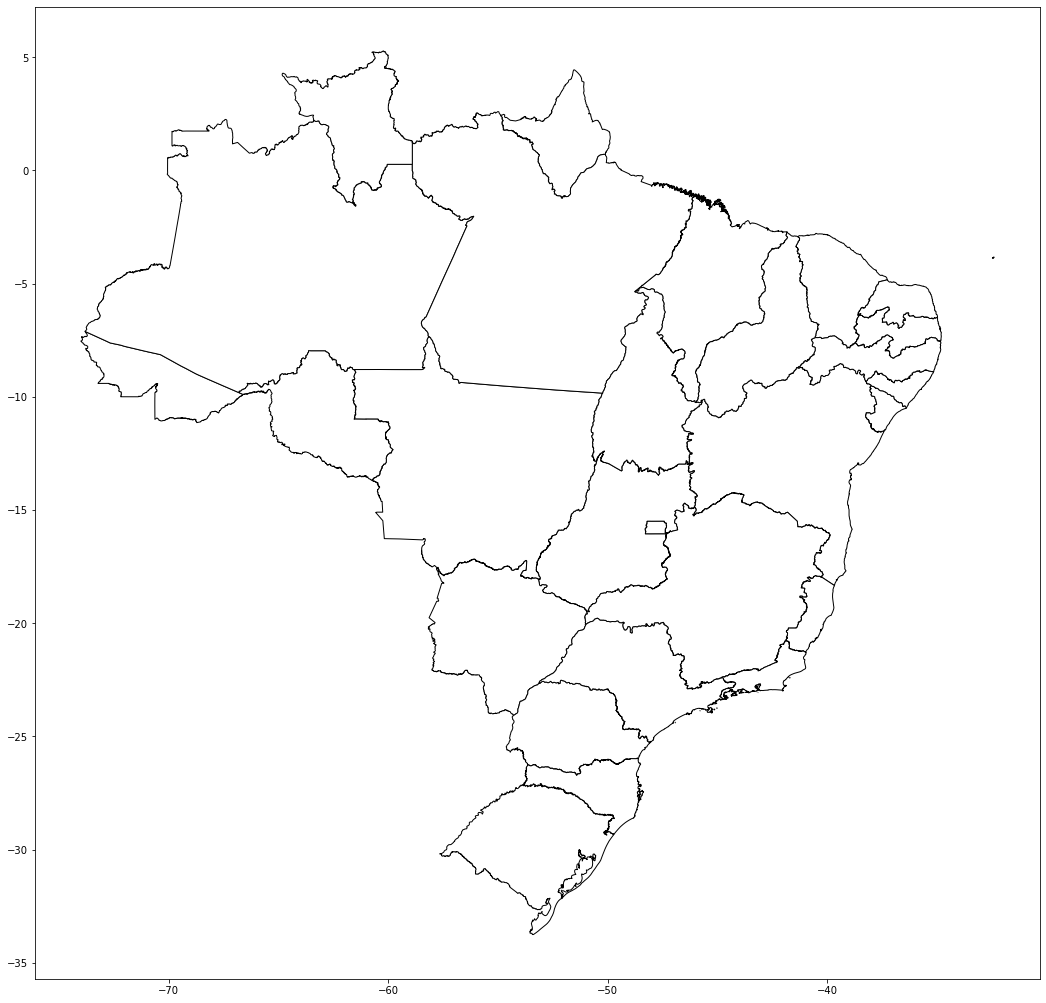

In [5]:
map.plot(color='white', edgecolor='black', figsize=(18,18))

### Logo acima é mostrado o mapa de modo mais claro sendo separado por estados. Optamos por pegar um geojson com separação por estados e não por cidades unicamente para facilitar as visualizações, pois a informação fica mais nítida nesse ambiente mais "limpo", além de que as delimitações de cada cidade não fariam diferença significativa em nossa análise.

<AxesSubplot:>

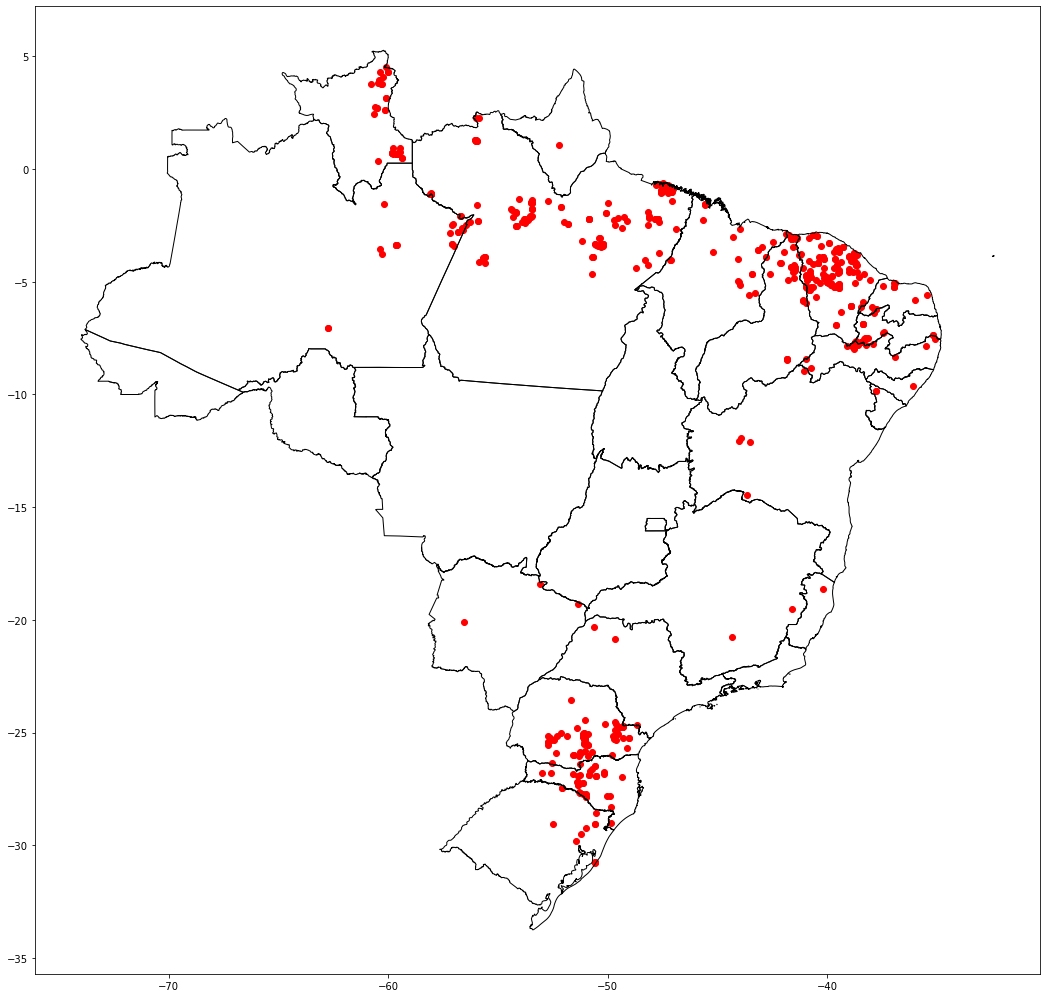

In [6]:
ax = map.plot(figsize=(18,18), color='none', edgecolor='black', zorder=2)
data.plot(color='red', ax=ax)

### Aqui é possível notar que as queimadas tiveram focos bem específicos nesses 2 dias, muito ao norte/nordeste e também ao sul. Observamos que estados como o Ceará obtiveram grandes registros de queimadas, assim como estados próximos, que tiveram muitos casos mas nada como nesse estado. O sul do país também sofreu, principalmente nas cidades do centro-sul/sul do paraná e também em Santa Catarina.

In [7]:
plt.rcParams['figure.figsize'] = (13,13)

biomas = data.bioma.value_counts()
pct_caatinga = biomas['Caatinga'] * 100 / biomas.values.sum()
pct_mataatlantica = biomas['Mata Atlantica'] * 100 / biomas.values.sum()
pct_amazonia = biomas['Amazonia'] * 100 / biomas.values.sum()
pct_cerrado = biomas['Cerrado'] * 100 / biomas.values.sum()
pct_pampa = biomas['Pampa'] * 100 / biomas.values.sum()
pct_pantanal = biomas['Pantanal'] * 100 / biomas.values.sum()
print('Porcentagem de queimadas na Caatinga:', pct_caatinga) 
print('Porcentagem de queimadas na Amazônia:', pct_amazonia) 
print('Porcentagem de queimadas na Mata Atlântica:', pct_mataatlantica) 
print('Porcentagem de queimadas no Cerrado:', pct_cerrado) 
print('Porcentagem de queimadas no Pampa:', pct_pampa) 
print('Porcentagem de queimadas no Pantanal:', pct_pantanal) 


Porcentagem de queimadas na Caatinga: 40.2027027027027
Porcentagem de queimadas na Amazônia: 35.641891891891895
Porcentagem de queimadas na Mata Atlântica: 20.10135135135135
Porcentagem de queimadas no Cerrado: 3.2094594594594597
Porcentagem de queimadas no Pampa: 0.6756756756756757
Porcentagem de queimadas no Pantanal: 0.16891891891891891


<BarContainer object of 6 artists>

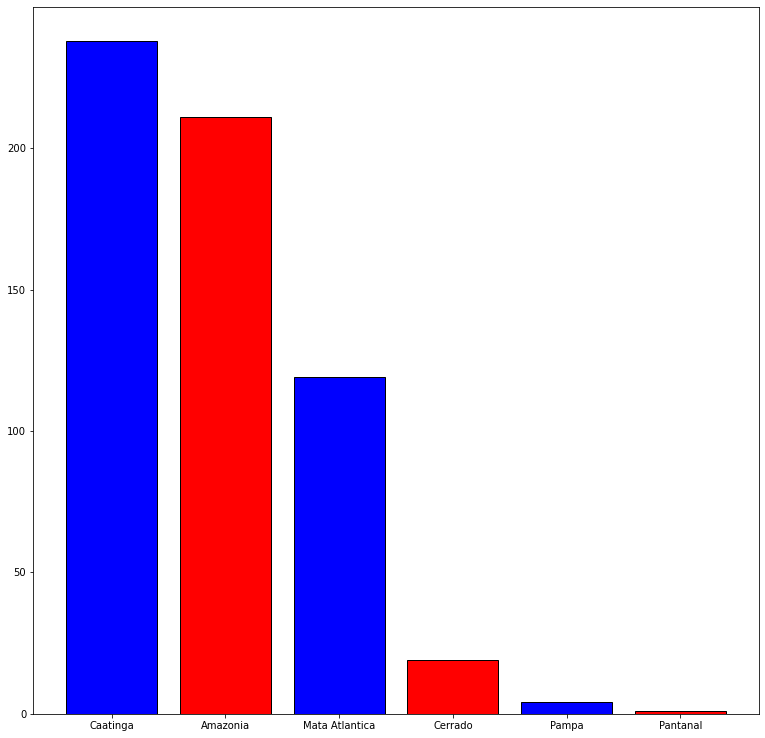

In [8]:
plt.bar(x=biomas.index.values, height=biomas.values,
        color=['blue', 'red'], edgecolor='black')

### Através desse gráfico é possível notar mais claramente onde cada queimada ocorreu, além de confirmar algo esperado: o bioma da Caatinga favorece as ocorrências de queimadas, enquanto o Pantanal raramente possui casos. Para ficar mais interessante, colocamos a porcentagem de queimadas de cada bioma também, logo acima do gráfico.

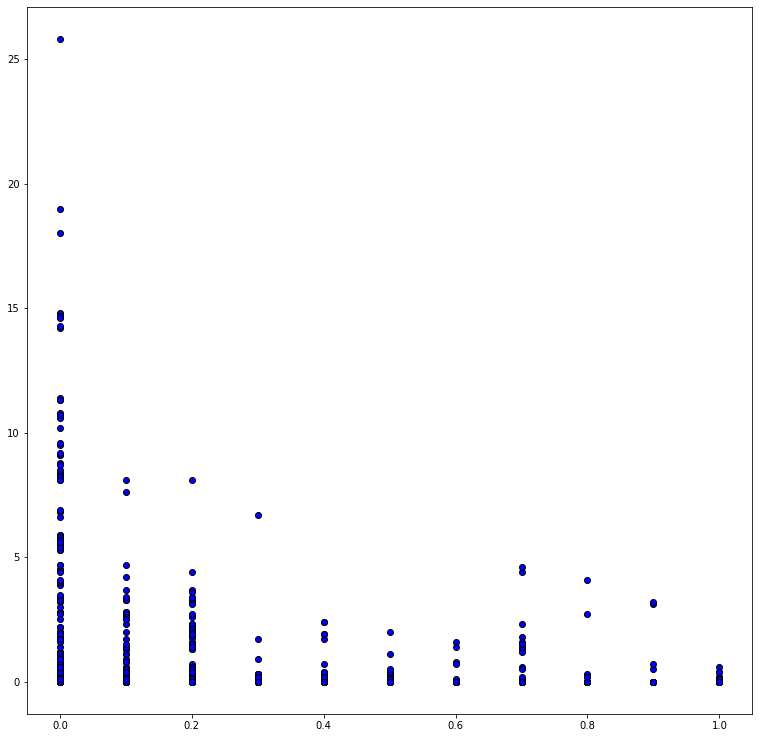

In [9]:
riscoprecip = data[['precipitacao', 'riscofogo']]
riscoprecip

plt.scatter(riscoprecip.riscofogo.values, riscoprecip.precipitacao.values,
            color='blue', edgecolor='black')


### Nessa nova visualização é retratada a relação da Precipitação de chuva (y) e do Risco Fogo (x) que cada lugar possui. Notamos que os lugares que possuem maior Risco Fogo possuem precipitações baixas.

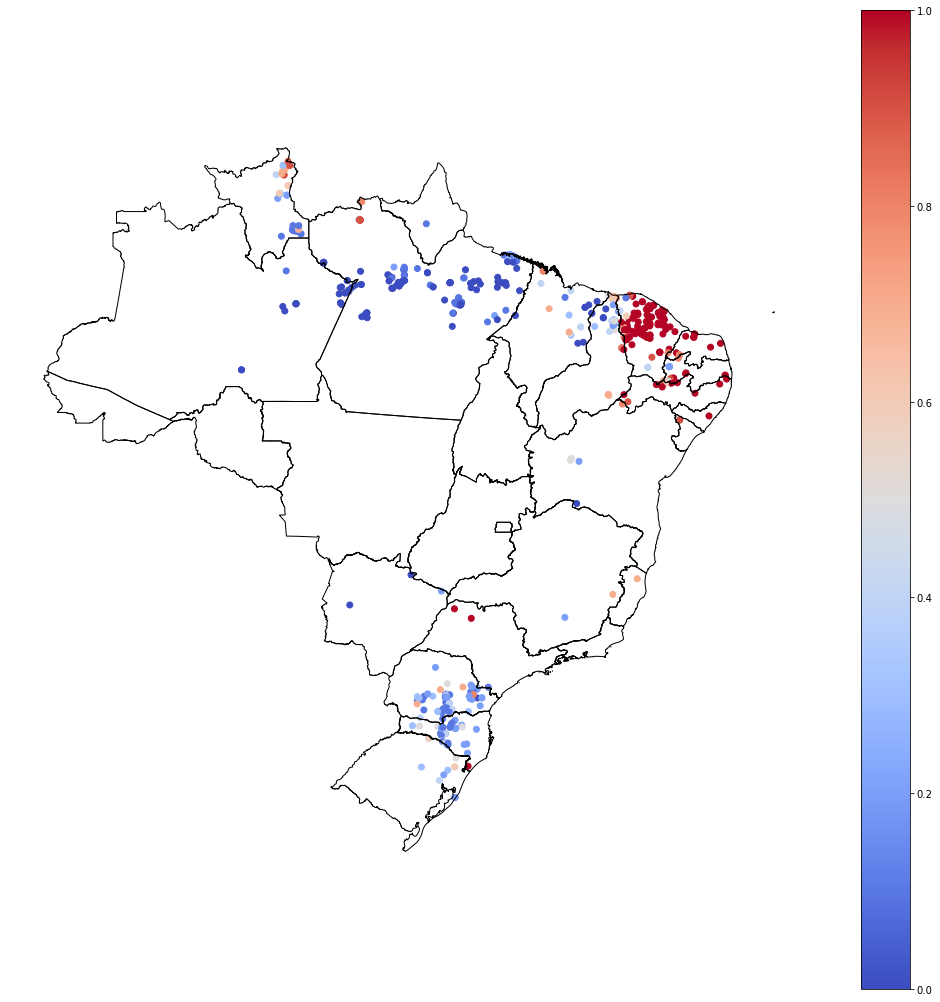

In [10]:
ax = map.plot(figsize=(18,18), color='none', edgecolor='black', zorder=2)
data.plot(ax=ax, column='riscofogo', cmap='coolwarm', legend=True)
ax.axis('off');

### Nesse novo mapa, podemos notar que os casos com maior risco fogo se concentram na Caatinga, e lugares com áreas mais chuvosas possuem menores taxas. Isso confirma a visualização anterior que analisamos a precipitação  e o risco fogo, mas agora, sob uma nova óptica.

### Em geral, é notável que as análises feitas neste trabalho condizem com o que esperamos na realidade, apesar de não ser possível termos uma ideia mais concreta dos focos de queimada no Brasil ao longo de um ano, pois a amostra usada foi de apenas dois dias seguidos. Apesar disso, conseguimos identificar os biomas que possuem tendência a ter focos de incêndio, além de como a precipitação de chuva interfere nessa situação.